In [ ]:
# pip install pandas numpy scikit-learn matplotlib tensorflow

In [52]:
import pandas as pd
import numpy as np
import IPython
import IPython.display
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau, ModelCheckpoint

In [2]:
# 1. Load the dataset
data = pd.read_csv('./data/BrentOilPricesMerged.csv')

In [3]:
# 2. Preprocess the data
# Convert Date to datetime format
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [4]:
data.head()

,Price,neg_oil,neu_oil,pos_oil,compound_oil,neg_war,neu_war,pos_war,compound_war
Date,,,,,,,,,
2023-04-03,84.930000,0.000,0.000,0.000,0.0000,0.000,0.000,0.000,0.0000
2023-04-04,84.940002,0.000,0.000,0.000,0.0000,0.000,0.000,0.000,0.0000
2023-04-05,84.989998,0.000,0.000,0.000,0.0000,0.000,0.000,0.000,0.0000
2023-04-06,85.120003,0.000,0.000,0.000,0.0000,0.000,0.776,0.224,0.9866
2023-04-10,84.180000,0.086,0.816,0.098,0.9796,0.144,0.708,0.147,-0.1356


In [6]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Price,271.0,82.667343,5.567707,71.839996,78.139999,82.739998,86.355000,96.550003
neg_oil,271.0,0.023033,0.024112,0.000000,0.000000,0.017500,0.038271,0.116000
neu_oil,271.0,0.496814,0.361231,0.000000,0.000000,0.604750,0.831000,0.960000
pos_oil,271.0,0.064340,0.055087,0.000000,0.000000,0.062000,0.100667,0.181000
compound_oil,271.0,0.378112,0.429797,-0.955900,0.000000,0.270900,0.950900,0.999900
neg_war,271.0,0.082097,0.071262,0.000000,0.013000,0.073000,0.132375,0.272500
neu_war,271.0,0.802173,0.128576,0.000000,0.773586,0.817200,0.854250,1.000000
pos_war,271.0,0.104691,0.065619,0.000000,0.066000,0.118000,0.139875,0.435000
compound_war,271.0,0.163507,0.595739,-0.999900,-0.357750,0.115525,0.701659,0.986600


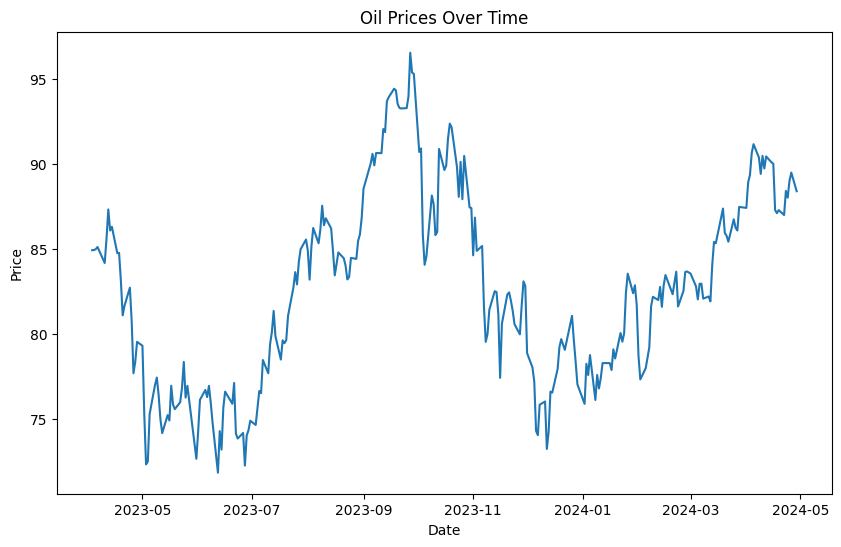

In [5]:
# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(data['Price'])
plt.title('Oil Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [33]:
column_indices = {name: i for i, name in enumerate(data.columns)}
column_indices

{'Price': 0,
 'neg_oil': 1,
 'neu_oil': 2,
 'pos_oil': 3,
 'compound_oil': 4,
 'neg_war': 5,
 'neu_war': 6,
 'pos_war': 7,
 'compound_war': 8}

In [15]:
# Extract the relevant columns for oil sentiment data
# oil_data = data[['Price', 'neg_oil', 'neu_oil', 'pos_oil', 'compound_oil', 'neg_war', 'neu_war', 'pos_war', 'compound_war']]
oil_data = data[['Price']]
oil_data.head()

,Price
Date,
2023-04-03,84.930000
2023-04-04,84.940002
2023-04-05,84.989998
2023-04-06,85.120003
2023-04-10,84.180000


In [8]:
# Normalize the price data
scaler = MinMaxScaler(feature_range=(0, 1))
# data['Price'] = scaler.fit_transform(data['Price'].values.reshape(-1, 1))
oil_data = scaler.fit_transform(oil_data)

In [16]:
n = len(oil_data)
train_df = oil_data[0:int(n*0.7)]
val_df = oil_data[int(n*0.7):int(n*0.9)]
test_df = oil_data[int(n*0.9):]

In [17]:
test_df

,Price
Date,
2024-03-20,85.949997
2024-03-21,85.779999
2024-03-22,85.430000
2024-03-25,86.750000
2024-03-26,86.250000
2024-03-27,86.089996
2024-03-28,87.480003
2024-04-01,87.419998
2024-04-02,88.919998


In [18]:
len(train_df),len(val_df),len(test_df)

(189, 54, 28)

In [21]:
train_df.columns

Index(['Price'], dtype='object')

In [22]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [26]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [28]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [37]:
def plot(self, model=None, plot_col='Price', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [29]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [31]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['Price'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['Price']

In [32]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [34]:
baseline = Baseline(label_index=column_indices['Price'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val, return_dict=True)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0, return_dict=True)

2/2 [==============================] - 0s 7ms/step - loss: 1.4231 - mean_absolute_error: 0.9591


In [38]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['Price'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['Price']

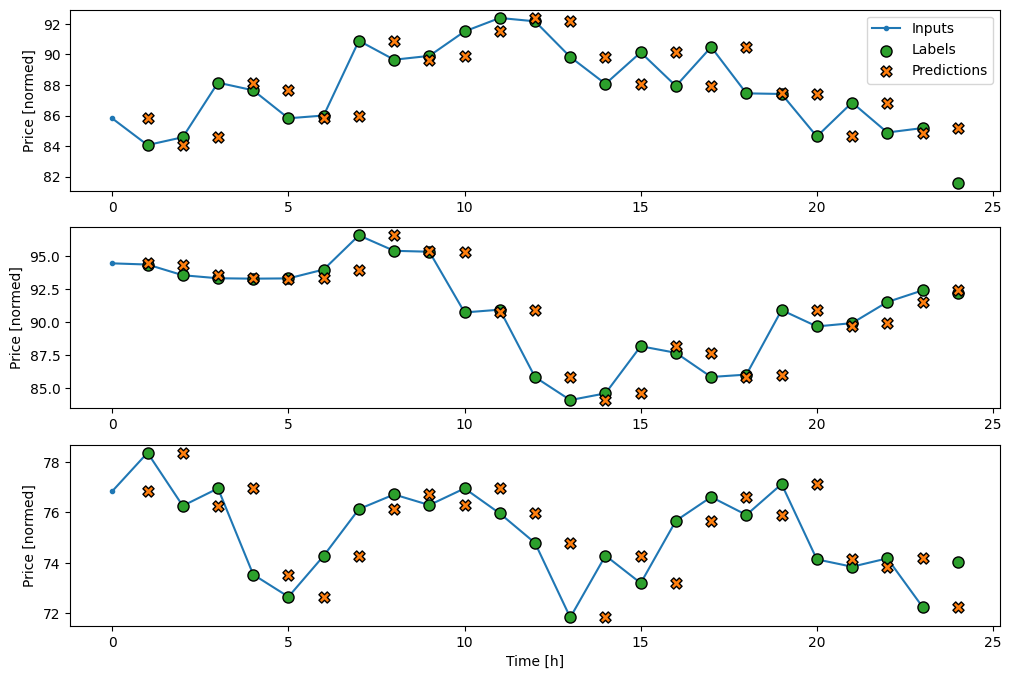

In [39]:
wide_window.plot(baseline)

1. Linear model

In [40]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [41]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 1)
Output shape: (32, 1, 1)


In [42]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [43]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val, return_dict=True)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0, return_dict=True)

Epoch 1/20
6/6 [==============================] - 0s 24ms/step - loss: 5821.8882 - mean_absolute_error: 76.0966 - val_loss: 5627.0898 - val_mean_absolute_error: 74.9734
Epoch 2/20
6/6 [==============================] - 0s 9ms/step - loss: 5745.7827 - mean_absolute_error: 75.5971 - val_loss: 5553.4028 - val_mean_absolute_error: 74.4808
Epoch 3/20
6/6 [==============================] - 0s 10ms/step - loss: 5670.3052 - mean_absolute_error: 75.0984 - val_loss: 5480.3022 - val_mean_absolute_error: 73.9889
Epoch 4/20
6/6 [==============================] - 0s 9ms/step - loss: 5595.4487 - mean_absolute_error: 74.6002 - val_loss: 5407.8384 - val_mean_absolute_error: 73.4980
Epoch 5/20
6/6 [==============================] - 0s 10ms/step - loss: 5521.0361 - mean_absolute_error: 74.1023 - val_loss: 5336.0942 - val_mean_absolute_error: 73.0087
Epoch 6/20
6/6 [==============================] - 0s 8ms/step - loss: 5447.4238 - mean_absolute_error: 73.6069 - val_loss: 5265.0142 - val_mean_absolute_erro

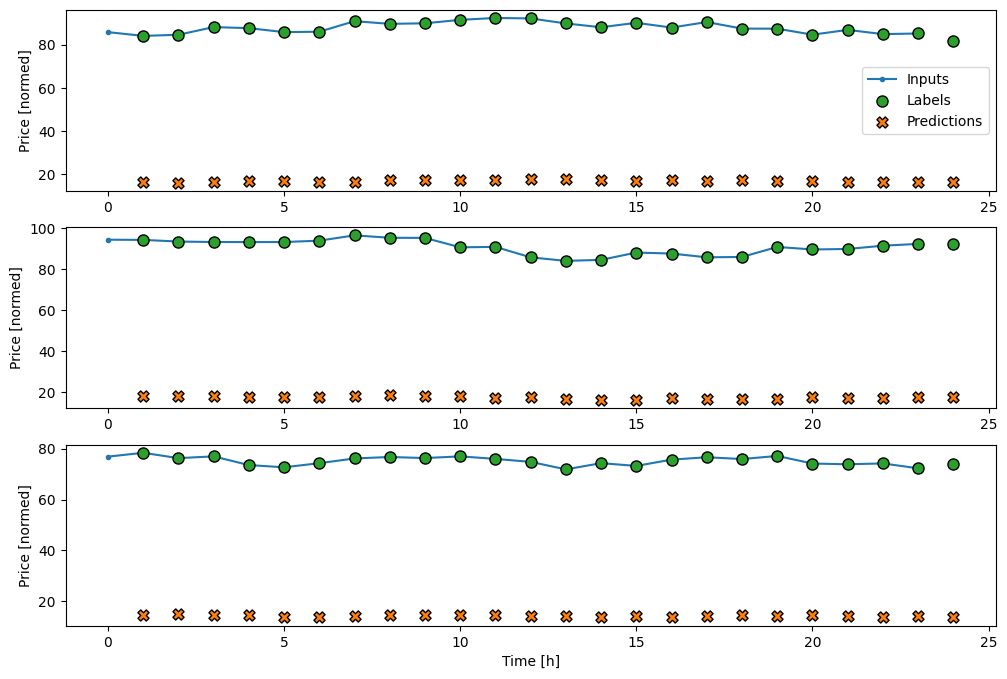

In [44]:
wide_window.plot(linear)

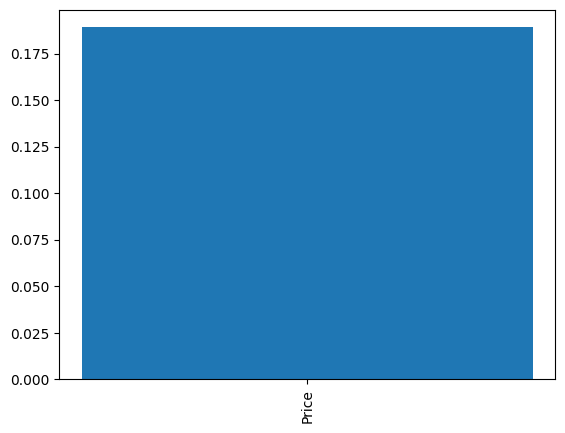

In [45]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

2. Dense

In [46]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val, return_dict=True)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0, return_dict=True)

Epoch 1/20
6/6 [==============================] - 1s 29ms/step - loss: 7593.9976 - mean_absolute_error: 86.8461 - val_loss: 6338.0200 - val_mean_absolute_error: 79.5692
Epoch 2/20
6/6 [==============================] - 0s 8ms/step - loss: 5872.2007 - mean_absolute_error: 76.3743 - val_loss: 4888.1758 - val_mean_absolute_error: 69.8768
Epoch 3/20
6/6 [==============================] - 0s 8ms/step - loss: 4464.2974 - mean_absolute_error: 66.5967 - val_loss: 3624.8904 - val_mean_absolute_error: 60.1718
Epoch 4/20
6/6 [==============================] - 0s 9ms/step - loss: 3258.7544 - mean_absolute_error: 56.8200 - val_loss: 2552.0520 - val_mean_absolute_error: 50.4854
Epoch 5/20
6/6 [==============================] - 0s 9ms/step - loss: 2239.3899 - mean_absolute_error: 47.0929 - val_loss: 1691.4369 - val_mean_absolute_error: 41.0963
Epoch 6/20
6/6 [==============================] - 0s 9ms/step - loss: 1429.0731 - mean_absolute_error: 37.5922 - val_loss: 1024.5840 - val_mean_absolute_error:

In [48]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['Price'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['Price']

Text(0.5, 0.98, 'Given 3 hours of inputs, predict 1 hour into the future.')

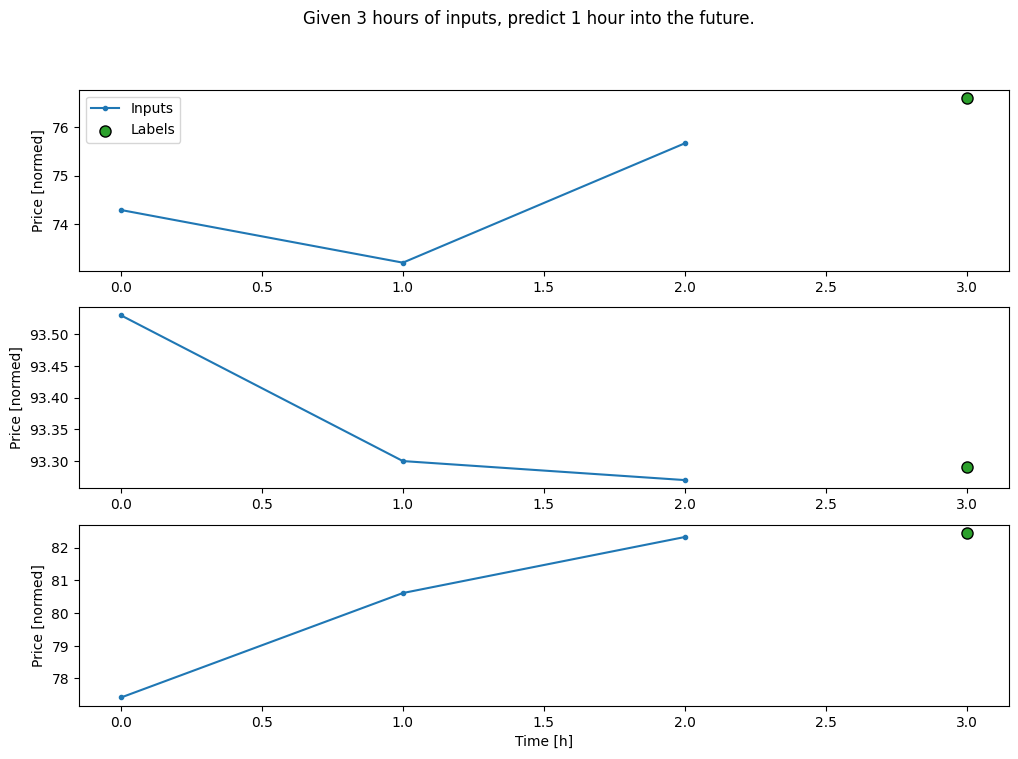

In [49]:
conv_window.plot()
plt.suptitle("Given 3 hours of inputs, predict 1 hour into the future.")

In [50]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [53]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val, return_dict=True)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0, return_dict=True)

2/2 [==============================] - 0s 3ms/step - loss: 1.8587 - mean_absolute_error: 1.0876


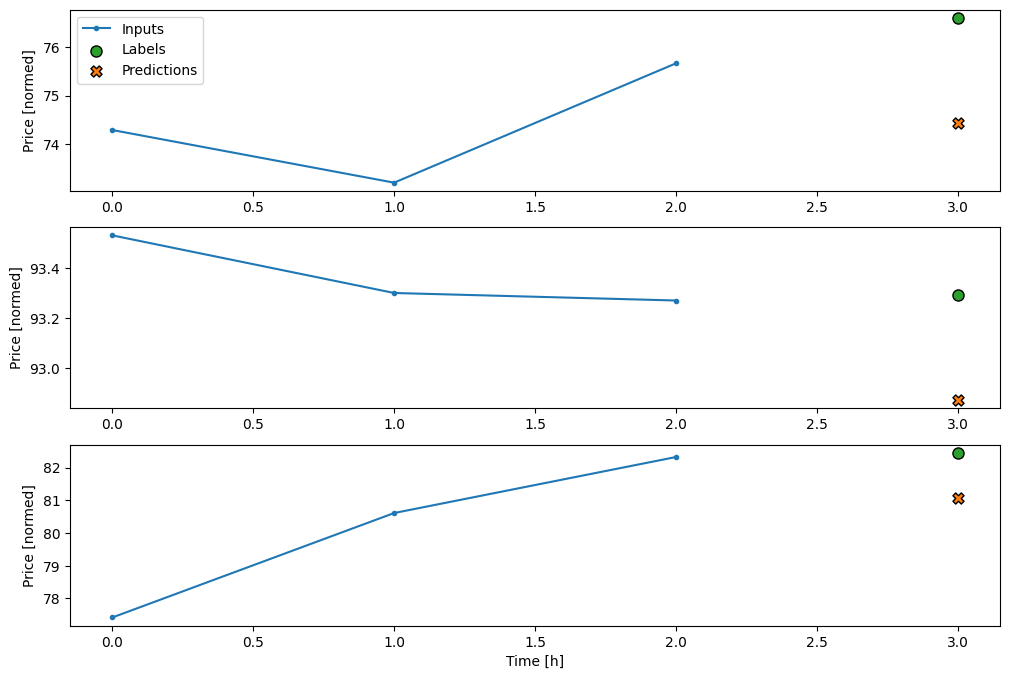

In [54]:
conv_window.plot(multi_step_dense)

3. Convolution neural network

In [55]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [56]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 1)
Output shape: (32, 1, 1)


In [57]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val, return_dict=True)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0, return_dict=True)

2/2 [==============================] - 0s 3ms/step - loss: 27.2801 - mean_absolute_error: 5.0169


In [58]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 1)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


In [63]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['Price'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['Price']

In [64]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 26, 1)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


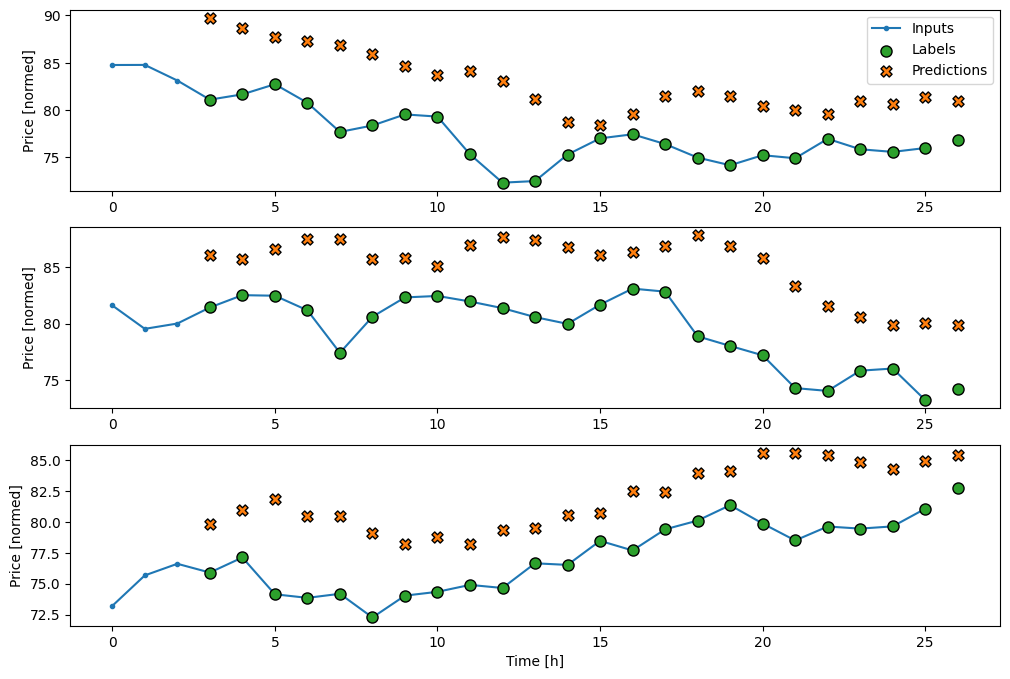

In [65]:
wide_conv_window.plot(conv_model)

4. Recurrent neural network

In [66]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [67]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 1)
Output shape: (32, 24, 1)


In [68]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val, return_dict=True)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0, return_dict=True)

1/1 [==============================] - 0s 48ms/step - loss: 5551.2588 - mean_absolute_error: 74.4774


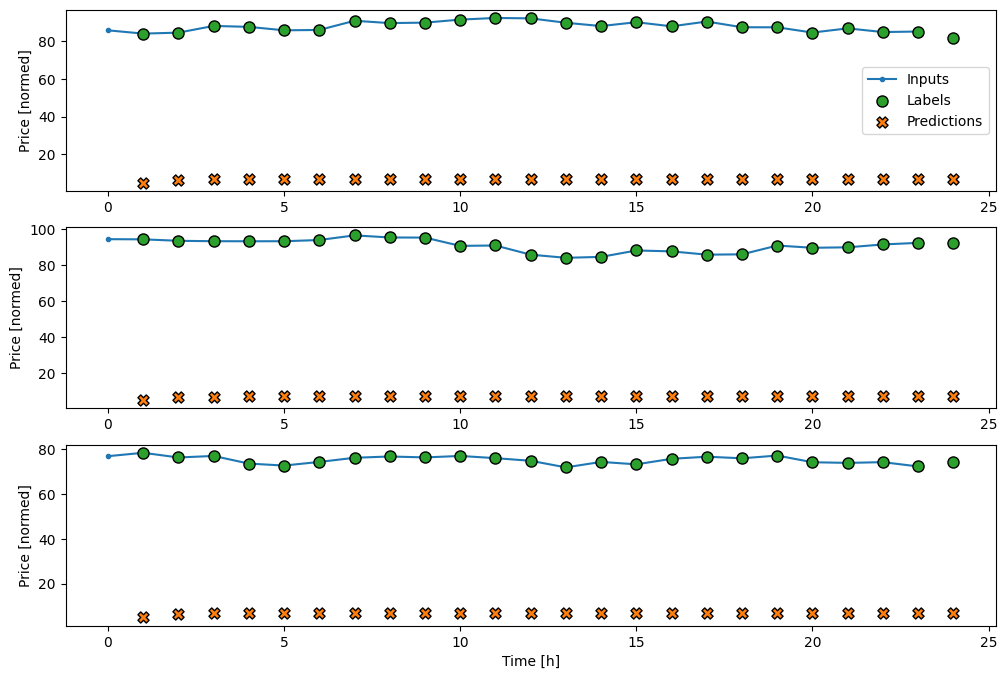

In [69]:
wide_window.plot(lstm_model)

In [70]:
cm = lstm_model.metrics[1]
cm.metrics

[]

In [71]:
val_performance

{'Baseline': {'loss': 1.423126220703125,
  'mean_absolute_error': 0.9590564966201782},
 'Linear': {'loss': 4342.0400390625, 'mean_absolute_error': 65.85693359375},
 'Dense': {'loss': 10.893733978271484,
  'mean_absolute_error': 3.076925039291382},
 'Multi step dense': {'loss': 1.8587143421173096,
  'mean_absolute_error': 1.0875506401062012},
 'Conv': {'loss': 27.28006935119629, 'mean_absolute_error': 5.01690673828125},
 'LSTM': {'loss': 5551.2587890625, 'mean_absolute_error': 74.47737884521484}}

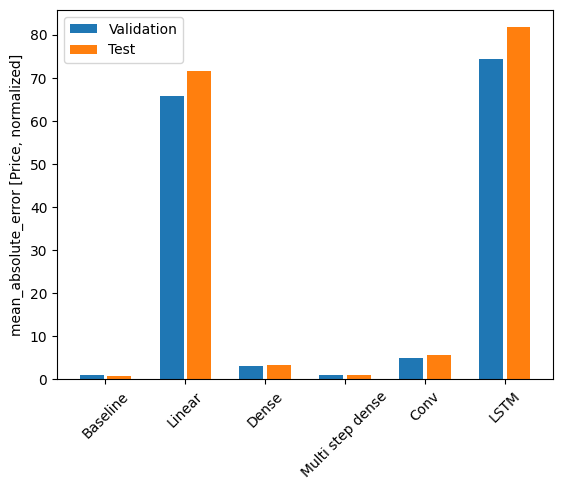

In [72]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
val_mae = [v[metric_name] for v in val_performance.values()]
test_mae = [v[metric_name] for v in performance.values()]

plt.ylabel('mean_absolute_error [Price, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [73]:
for name, value in performance.items():
  print(f'{name:12s}: {value[metric_name]:0.4f}')

Baseline    : 0.7470
Linear      : 71.6179
Dense       : 3.4580
Multi step dense: 0.9517
Conv        : 5.5984
LSTM        : 81.7002
